# Train YOLOX on COTS dataset

This notebook shows how to train custom object detection model (COTS dataset) on Kaggle. It could be good starting point for build own custom model based on YOLOX detector. Full github repository you can find here - [YOLOX](https://github.com/Megvii-BaseDetection/YOLOX)

# 0. SETUP COLAB ENVIRONMENT

In [ ]:
!nvidia-smi

Thu Feb 10 03:58:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# check environment
import os
IN_COLAB = 'COLAB_GPU' in os.environ.keys()
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if IN_COLAB:
    !pip install -U numba
    #!pip install torch==1.9.1 torchaudio==0.9.1 torchmetrics==0.6.2 torchaudio==0.9.1 torchvision==0.10.1
    ## for A100 GPU
    !pip install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip list | grep torch

In [ ]:
!cp /content/drive/MyDrive/workspace/great_barrier_reef/tensorflow-great-barrier-reef.zip ./
!unzip ./tensorflow-great-barrier-reef.zip

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import ast
import os
import json
import pandas as pd
import torch
import importlib
import cv2 

from shutil import copyfile
from tqdm.notebook import tqdm
tqdm.pandas()
import numpy as np
from sklearn.model_selection import GroupKFold
from PIL import Image
from string import Template
from IPython.display import display

if IN_COLAB:
    TRAIN_PATH = '/content'
else:
    TRAIN_PATH = '/kaggle/input/tensorflow-great-barrier-reef'

In [ ]:
# check Torch and CUDA version
print(f"Torch: {torch.__version__}")
!nvcc --version

Torch: 1.9.1+cu111
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!cp /content/drive/MyDrive/workspace/great_barrier_reef/train-5folds.csv .

# 1. INSTALL YOLOX

In [ ]:
#!git clone https://github.com/Megvii-BaseDetection/YOLOX -q

!cp -R /content/drive/MyDrive/workspace/great_barrier_reef/YOLOX /content

%cd YOLOX
!pip install -U pip && pip install -r requirements.txt
!pip install -v -e . 

/content/YOLOX
     |████████████████████████████████| 1.7 MB 14.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 57 kB 4.8 MB/s             
     |████████████████████████████████| 108 kB 30.6 MB/s            
     |████████████████████████████████| 14.5 MB 52.2 MB/s            
     |████████████████████████████████| 4.5 MB 41.4 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 466 kB 67.8 MB/s            
  Created wheel for onnx-simplifier: filename=onnx_simplifier-0.3.5-py3-none-any.whl size=12878 sha256=b3a05ec4a93681bf0dbab409996959bda1d9d212e9ee2f1ce427e8e52fb78910
  Stored in directory: /root/.cache/pip/wheels/8a/b4/1b/6acdd4eb854b215cd4aa1c18ca79399f9d34728edaff47ecce
Successfully built onnx-simplifier
Using pip 21.3.1 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Obtaining 

In [ ]:
#!cp -R /content/YOLOX /content/drive/MyDrive/workspace/great_barrier_reef

In [ ]:
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-057pkzt6
  Running command git clone --filter=blob:none -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-057pkzt6
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263956 sha256=b038dbc501650277ef24cbb33bcd3c04c47d6c4b5d94d3ae9a205533cf5ea284
  Stored in directory: /tmp/pip-ephem-wheel-cache-w2bpaemq/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


# 2. PREPARE COTS DATASET FOR YOLOX
This section is taken from  notebook created by Awsaf [Great-Barrier-Reef: YOLOv5 train](https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-train)

## A. PREPARE DATASET AND ANNOTATIONS

In [ ]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_path(row):
    row['image_path'] = f'{TRAIN_PATH}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row

In [ ]:
df = pd.read_csv(f"{TRAIN_PATH}/train.csv")
print(df.shape)
df.head(5)

(23501, 6)


,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]


In [ ]:
# Taken only annotated photos
df["num_bbox"] = df['annotations'].apply(lambda x: str.count(x, 'x'))
df_train = df[df["num_bbox"]>0]

#Annotations 
df_train['annotations'] = df_train['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df_train['bboxes'] = df_train.annotations.progress_apply(get_bbox)

#Images resolution
df_train["width"] = 1280
df_train["height"] = 720

#Path of images
df_train = df_train.progress_apply(get_path, axis=1)

  0%|          | 0/4919 [00:00<?, ?it/s]

  0%|          | 0/4919 [00:00<?, ?it/s]

  0%|          | 0/4919 [00:00<?, ?it/s]

In [ ]:
kf = GroupKFold(n_splits = 5) 
df_train = df_train.reset_index(drop=True)
df_train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df_train, y = df_train.video_id.tolist(), groups=df_train.sequence)):
    df_train.loc[val_idx, 'fold'] = fold

df_train.head(5)

In [ ]:
!rm -r /content/dataset
!echo 'sleep 3sec'
!sleep 3

sleep 3sec


In [ ]:
if IN_COLAB:
    HOME_DIR = '/content/'
else:
    HOME_DIR = '/kaggle/working/' 

DATASET_PATH = 'dataset/images'

!mkdir {HOME_DIR}dataset
!mkdir {HOME_DIR}{DATASET_PATH}
!mkdir {HOME_DIR}{DATASET_PATH}/train2017
!mkdir {HOME_DIR}{DATASET_PATH}/val2017
!mkdir {HOME_DIR}{DATASET_PATH}/annotations

In [ ]:
SELECTED_FOLD = 2

for i in tqdm(range(len(df_train))):
    row = df_train.loc[i]
    if row.fold != SELECTED_FOLD:
        copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/train2017/{row.image_id}.jpg')
    else:
        copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/val2017/{row.image_id}.jpg') 

  0%|          | 0/4919 [00:00<?, ?it/s]

In [ ]:
print(f'Number of training files: {len(os.listdir(f"{HOME_DIR}{DATASET_PATH}/train2017/"))}')
print(f'Number of validation files: {len(os.listdir(f"{HOME_DIR}{DATASET_PATH}/val2017/"))}')

Number of training files: 4242
Number of validation files: 677


## A2. SUBSEQUENCE VERSION

In [ ]:
if IN_COLAB:
    HOME_DIR = '/content/'
else:
    HOME_DIR = '/kaggle/working/' 

DATASET_PATH = 'dataset/images'

!mkdir -p {HOME_DIR}{DATASET_PATH}/train2017
!mkdir -p {HOME_DIR}{DATASET_PATH}/val2017
!mkdir -p {HOME_DIR}{DATASET_PATH}/annotations

In [ ]:
df = pd.read_csv(f"{TRAIN_PATH}/train-5folds.csv")
print(df.shape)
df[df['has_annotations']].head()

(23501, 11)


,video_id,sequence,video_frame,sequence_frame,image_id,annotations,n_annotations,has_annotations,image_path,subsequence_id,fold
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",1,True,../input/tensorflow-great-barrier-reef/train_i...,2,4
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",1,True,../input/tensorflow-great-barrier-reef/train_i...,2,4
18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",1,True,../input/tensorflow-great-barrier-reef/train_i...,2,4
19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",1,True,../input/tensorflow-great-barrier-reef/train_i...,2,4
20,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",1,True,../input/tensorflow-great-barrier-reef/train_i...,2,4


In [ ]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_path(row):
    row['image_path'] = f'{TRAIN_PATH}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row

In [ ]:
#Annotations 
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df['bboxes'] = df.annotations.progress_apply(get_bbox)

#Images resolution
df["width"] = 1280
df["height"] = 720

#Path of images
df = df.progress_apply(get_path, axis=1)

# Taken only annotated photos
df_train = df[df['has_annotations'] == True]

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

In [ ]:
df.shape, df_train.shape

((23501, 14), (4919, 14))

In [ ]:
SELECTED_FOLD = 0

for i in tqdm(range(len(df))):
    row = df.loc[i]
    if row.fold != SELECTED_FOLD:
        copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/train2017/{row.image_id}.jpg')
    else:
        copyfile(f'{row.image_path}', f'{HOME_DIR}{DATASET_PATH}/val2017/{row.image_id}.jpg')

  0%|          | 0/23501 [00:00<?, ?it/s]

In [ ]:
print(f'Number of training files: {len(os.listdir(f"{HOME_DIR}{DATASET_PATH}/train2017/"))}')
print(f'Number of validation files: {len(os.listdir(f"{HOME_DIR}{DATASET_PATH}/val2017/"))}')
df_train[df_train['fold'] != SELECTED_FOLD].shape[0],df_train[df_train['fold'] == SELECTED_FOLD].shape[0]

Number of training files: 18278
Number of validation files: 5223


(4073, 846)

## B. CREATE COCO ANNOTATION FILES

In [ ]:
def save_annot_json(json_annotation, filename):
    with open(filename, 'w') as f:
        output_json = json.dumps(json_annotation)
        f.write(output_json)

In [ ]:
annotion_id = 0

In [ ]:
def dataset2coco(df, dest_path):
    
    global annotion_id
    
    annotations_json = {
        "info": [],
        "licenses": [],
        "categories": [],
        "images": [],
        "annotations": []
    }
    
    info = {
        "year": "2021",
        "version": "1",
        "description": "COTS dataset - COCO format",
        "contributor": "",
        "url": "https://kaggle.com",
        "date_created": "2021-11-30T15:01:26+00:00"
    }
    annotations_json["info"].append(info)
    
    lic = {
            "id": 1,
            "url": "",
            "name": "Unknown"
        }
    annotations_json["licenses"].append(lic)

    classes = {"id": 0, "name": "starfish", "supercategory": "none"}

    annotations_json["categories"].append(classes)

    
    for ann_row in df.itertuples():
            
        images = {
            "id": ann_row[0],
            "license": 1,
            "file_name": ann_row.image_id + '.jpg',
            "height": ann_row.height,
            "width": ann_row.width,
            "date_captured": "2021-11-30T15:01:26+00:00"
        }
        
        annotations_json["images"].append(images)
        
        bbox_list = ann_row.bboxes
        
        for bbox in bbox_list:
            b_width = bbox[2]
            b_height = bbox[3]
            
            # some boxes in COTS are outside the image height and width
            if (bbox[0] + bbox[2] > 1280):
                b_width = bbox[0] - 1280 
            if (bbox[1] + bbox[3] > 720):
                b_height = bbox[1] - 720 
                
            image_annotations = {
                "id": annotion_id,
                "image_id": ann_row[0],
                "category_id": 0,
                "bbox": [bbox[0], bbox[1], b_width, b_height],
                "area": bbox[2] * bbox[3],
                "segmentation": [],
                "iscrowd": 0
            }
            
            annotion_id += 1
            annotations_json["annotations"].append(image_annotations)
        
        
    print(f"Dataset COTS annotation to COCO json format completed! Files: {len(df)}")
    return annotations_json

In [ ]:
# Convert COTS dataset to JSON COCO
train_annot_json = dataset2coco(df_train[df_train.fold != SELECTED_FOLD], f"{HOME_DIR}{DATASET_PATH}/train2017/")
val_annot_json = dataset2coco(df_train[df_train.fold == SELECTED_FOLD], f"{HOME_DIR}{DATASET_PATH}/val2017/")

# Save converted annotations
save_annot_json(train_annot_json, f"{HOME_DIR}{DATASET_PATH}/annotations/train.json")
save_annot_json(val_annot_json, f"{HOME_DIR}{DATASET_PATH}/annotations/valid.json")

Dataset COTS annotation to COCO json format completed! Files: 4073
Dataset COTS annotation to COCO json format completed! Files: 846


In [ ]:
df_train[df_train['fold'] == 0].head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,n_annotations,has_annotations,image_path,subsequence_id,fold,bboxes,width,height
485,0,45518,878,5,0-878,"[{'x': 720, 'y': 679, 'width': 55, 'height': 40}]",1,True,/content/train_images/video_0/878.jpg,11,0,"[[720, 679, 55, 40]]",1280,720
486,0,45518,879,6,0-879,"[{'x': 718, 'y': 661, 'width': 54, 'height': 45}]",1,True,/content/train_images/video_0/879.jpg,11,0,"[[718, 661, 54, 45]]",1280,720
487,0,45518,880,7,0-880,"[{'x': 719, 'y': 649, 'width': 50, 'height': 39}]",1,True,/content/train_images/video_0/880.jpg,11,0,"[[719, 649, 50, 39]]",1280,720
488,0,45518,881,8,0-881,"[{'x': 712, 'y': 634, 'width': 53, 'height': 41}]",1,True,/content/train_images/video_0/881.jpg,11,0,"[[712, 634, 53, 41]]",1280,720
489,0,45518,882,9,0-882,"[{'x': 712, 'y': 624, 'width': 51, 'height': 38}]",1,True,/content/train_images/video_0/882.jpg,11,0,"[[712, 624, 51, 38]]",1280,720


# 3. PREPARE CONFIGURATION FILE

Configuration files for Yolox:
- [YOLOX-s](https://github.com/Megvii-BaseDetection/YOLOX/blob/main/exps/default/yolox_s.py)
- [YOLOX-m](https://github.com/Megvii-BaseDetection/YOLOX/blob/main/exps/default/yolox_m.py)
- [YOLOX-l](https://github.com/Megvii-BaseDetection/YOLOX/blob/main/exps/default/yolox_l.py)

<div class="alert alert-warning">
<strong> For YOLOX_s I use input size 960x960 but you can change it for your experiments.</strong> 
</div>
Manipulating Your Training Image Size　

https://github.com/Megvii-BaseDetection/YOLOX/blob/main/docs/manipulate_training_image_size.md

In [ ]:
# yolox-l
config_file_template = '''
#!/usr/bin/env python3
# -*- coding:utf-8 -*-
# Copyright (c) Megvii, Inc. and its affiliates.

import os

from yolox.exp import Exp as MyExp


class Exp(MyExp):
    def __init__(self):
        super(Exp, self).__init__()
        self.depth = 1.0
        self.width = 1.0
        self.exp_name = os.path.split(os.path.realpath(__file__))[1].split(".")[0]

        # Define yourself dataset path
        #self.data_dir = "/kaggle/working/dataset/images"
        self.data_dir = "/content/dataset/images"
        self.train_ann = "train.json"
        self.val_ann = "valid.json"

        self.num_classes = 1

        self.max_epoch = $max_epoch
        self.data_num_workers = 4
        self.eval_interval = 1
        
        self.mosaic_prob = 0.5 #1.0
        self.mixup_prob = 1.0
        self.hsv_prob = 1.0
        self.flip_prob = 0.5
        self.no_aug_epochs = 2
        self.degrees = 10.0
        self.translate = 0.1
        self.scale = (0.1, 2)
        self.mosaic_scale = (0.5, 1.5)
        self.shear = 2.0
        #self.perspective = 0.0
        self.enable_mixup = True

        self.input_size = (1024, 1920)  # (800, 1280)
        self.multiscale_range = 10
        #self.random_size = (10, 20)
        self.test_size = (1024, 1920)
'''

In [ ]:
PIPELINE_CONFIG_PATH='cots_config.py'

pipeline = Template(config_file_template).substitute(max_epoch = 25)

with open(PIPELINE_CONFIG_PATH, 'w') as f:
    f.write(pipeline)

In [ ]:
!pwd
%cd YOLOX

/content/YOLOX
[Errno 2] No such file or directory: 'YOLOX'
/content/YOLOX


In [ ]:
# ./yolox/data/datasets/voc_classes.py

voc_cls = '''
VOC_CLASSES = (
  "starfish",
)
'''
with open('./yolox/data/datasets/voc_classes.py', 'w') as f:
    f.write(voc_cls)

# ./yolox/data/datasets/coco_classes.py

coco_cls = '''
COCO_CLASSES = (
  "starfish",
)
'''
with open('./yolox/data/datasets/coco_classes.py', 'w') as f:
    f.write(coco_cls)

# check if everything is ok    
!more ./yolox/data/datasets/coco_classes.py


COCO_CLASSES = (
  "starfish",
)


# 5. TRAIN MODEL

In [ ]:
MODEL_FILE = 'yolox_l.pth'

In [ ]:
!cp ./tools/train.py ./

In [ ]:
!rm -r /content/YOLOX/YOLOX_outputs
!ls /content/YOLOX

assets		demo	     LICENSE	       setup.cfg  yolox
build		docs	     __pycache__       setup.py   yolox.egg-info
cots_config.py	experiments  README.md	       tools	  yolox_l.pth
datasets	exps	     requirements.txt  train.py   yolox_s.pth


In [ ]:
!python train.py --help

In [ ]:
!python train.py \
    -f cots_config.py \
    -d 1 \
    -b 2 \
    --fp16 \
    -o \
    -c {MODEL_FILE}

# 6. RUN INFERENCE

## 6A. INFERENCE USING YOLOX TOOL

In [ ]:
#%cd YOLOX 

/content/YOLOX


In [ ]:
!echo "sleep 60sec"
!sleep 60
!cp -R YOLOX_outputs /content/drive/MyDrive/workspace/great_barrier_reef/experiments
!echo "copy ok"

sleep 60sec
copy ok


In [ ]:
!cp -R /content/drive/MyDrive/workspace/great_barrier_reef/experiments/YOLOX_outputs_0118 ./YOLOX_outputs

## 6B. INFERENCE USING CUSTOM SCRIPT (IT WOULD BE USED FOR COTS INFERENCE PART)

### 6B.1 SETUP MODEL

In [ ]:
!cp tools/demo.py .

In [ ]:
!python tools/demo.py --help

usage: YOLOX Demo! [-h] [-expn EXPERIMENT_NAME] [-n NAME] [--path PATH]
                   [--camid CAMID] [--save_result] [-f EXP_FILE] [-c CKPT]
                   [--device DEVICE] [--conf CONF] [--nms NMS] [--tsize TSIZE]
                   [--fp16] [--legacy] [--fuse] [--trt]
                   demo

positional arguments:
  demo                  demo type, eg. image, video and webcam

optional arguments:
  -h, --help            show this help message and exit
  -expn EXPERIMENT_NAME, --experiment-name EXPERIMENT_NAME
  -n NAME, --name NAME  model name
  --path PATH           path to images or video
  --camid CAMID         webcam demo camera id
  --save_result         whether to save the inference result of image/video
  -f EXP_FILE, --exp_file EXP_FILE
                        pls input your experiment description file
  -c CKPT, --ckpt CKPT  ckpt for eval
  --device DEVICE       device to run our model, can either be cpu or gpu
  --conf CONF           test conf
  --nms NMS        

In [ ]:
df_train[(df_train['fold'] == 0) & (df_train['n_annotations'] == 4)].head(1)

In [ ]:
!cp -R /content/drive/MyDrive/workspace/great_barrier_reef/experiments/YOLOX_outputs_0118 /content/YOLOX/YOLOX_outputs

In [ ]:
TEST_IMAGE_PATH = "/content/dataset/images/val2017/0-9636.jpg"
MODEL_PATH = "./YOLOX_outputs/cots_config/best_ckpt.pth"

!python tools/demo.py image \
    -f cots_config.py \
    -c {MODEL_PATH} \
    --path {TEST_IMAGE_PATH} \
    --conf 0.1 \
    --nms 0.35 \
    --tsize 1024 \
    --save_result \
    --device gpu

In [ ]:
OUTPUT_IMAGE_PATH = "/content/YOLOX/YOLOX_outputs/cots_config/vis_res/2022_01_19_14_22_24/0-9636.jpg"
Image.open(OUTPUT_IMAGE_PATH)

## INFERENCE CODE

In [ ]:
from yolox.utils import postprocess
from yolox.data.data_augment import ValTransform

COCO_CLASSES = (
  "starfish",
)

# get YOLOX experiment
current_exp = importlib.import_module('cots_config')
exp = current_exp.Exp()

# get YOLOX model
model = exp.get_model()
model.cuda()
model.eval()

# get custom trained checkpoint
ckpt_file = "./YOLOX_outputs/cots_config/best_ckpt.pth"
ckpt = torch.load(ckpt_file, map_location="cpu")
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [ ]:
# set inference parameters
test_size = (1024, 1920) #(800, 1280)
num_classes = 1
confthre = 0.01
nmsthre = 0.35

### 6B.2 INFERENCE BBOXES

In [ ]:
def yolox_inference(img, model, test_size): 
    bboxes = []
    bbclasses = []
    scores = []
    
    preproc = ValTransform(legacy = False)

    tensor_img, _ = preproc(img, None, test_size)
    tensor_img = torch.from_numpy(tensor_img).unsqueeze(0)
    tensor_img = tensor_img.float()
    tensor_img = tensor_img.cuda()

    with torch.no_grad():
        outputs = model(tensor_img)
        outputs = postprocess(outputs, num_classes, confthre, nmsthre, class_agnostic=True)

    if outputs[0] is None:
        return [], [], []
    
    outputs = outputs[0].cpu()
    bboxes = outputs[:, 0:4]

    bboxes /= min(test_size[0] / img.shape[0], test_size[1] / img.shape[1])
    bbclasses = outputs[:, 6]
    scores = outputs[:, 4] * outputs[:, 5]
    
    return bboxes, bbclasses, scores

### 6B.3 DRAW RESULT

In [ ]:
def draw_yolox_predictions(img, bboxes, scores, bbclasses, confthre, classes_dict):
    for i in range(len(bboxes)):
        box = bboxes[i]
        cls_id = int(bbclasses[i])
        score = scores[i]
        if score < confthre:
            continue
        x0 = int(box[0])
        y0 = int(box[1])
        x1 = int(box[2])
        y1 = int(box[3])

        cv2.rectangle(img, (x0, y0), (x1, y1), (0, 255, 0), 2)
        cv2.putText(img, '{}:{:.1f}%'.format(classes_dict[cls_id], score * 100), (x0, y0 - 3), cv2.FONT_HERSHEY_PLAIN, 0.8, (0,255,0), thickness = 1)
    return img

### 6B.4 ALL PUZZLES TOGETHER

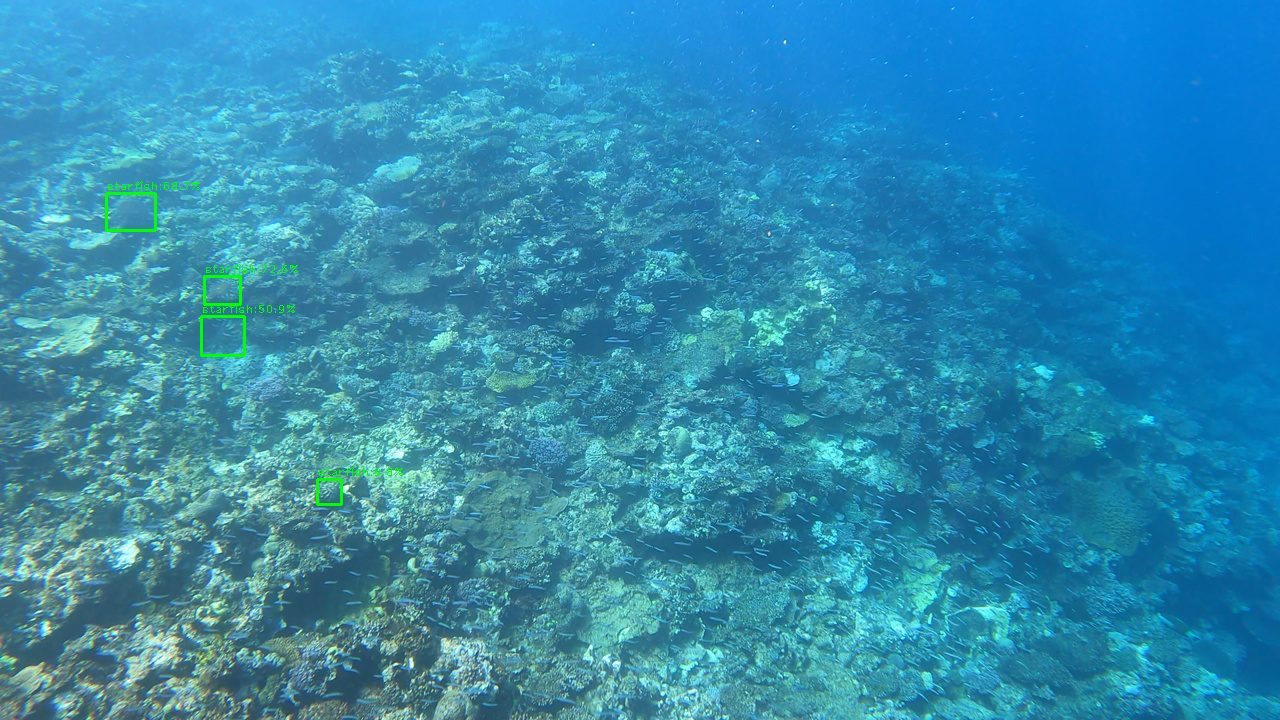

In [ ]:
if IN_COLAB:
    TEST_IMAGE_PATH = '/content/dataset/images/val2017/0-9636.jpg'
else:
    TEST_IMAGE_PATH = "/kaggle/working/dataset/images/val2017/0-9636.jpg"

img = cv2.imread(TEST_IMAGE_PATH)

# Get predictions
bboxes, bbclasses, scores = yolox_inference(img, model, test_size)

# Draw predictions
out_image = draw_yolox_predictions(img, bboxes, scores, bbclasses, confthre, COCO_CLASSES)

# Since we load image using OpenCV we have to convert it 
out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
display(Image.fromarray(out_image))

# Global f2 metric implementation
In version 1 I've implemented image-wise metric, but competition metric shoud gather tp/fp/fn over all images and then calculate f2 score.  
It means above metric is somehow wrong, but I'll keep it here as it might be useful for someone want to calculate image-wise metric.

Anyway, let's implement correct metric:)

In [ ]:
def calc_iou(bboxes1, bboxes2, bbox_mode='xywh'):
    assert len(bboxes1.shape) == 2 and bboxes1.shape[1] == 4
    assert len(bboxes2.shape) == 2 and bboxes2.shape[1] == 4
    
    bboxes1 = bboxes1.copy()
    bboxes2 = bboxes2.copy()
    
    if bbox_mode == 'xywh':
        bboxes1[:, 2:] += bboxes1[:, :2]
        bboxes2[:, 2:] += bboxes2[:, :2]

    x11, y11, x12, y12 = np.split(bboxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

def f_beta(tp, fp, fn, beta=2):
    return 5*tp / (5*tp + 4*fn + fp)
    #return (1+beta**2)*tp / ((1+beta**2)*tp + beta**2*fn+fp)

def calc_is_correct_at_iou_th(gt_bboxes, pred_bboxes, iou_th, verbose=False):
    gt_bboxes = gt_bboxes.copy()
    pred_bboxes = pred_bboxes.copy()
    
    tp = 0
    fp = 0
    for k, pred_bbox in enumerate(pred_bboxes): # fixed in ver.7
        ious = calc_iou(gt_bboxes, pred_bbox[None, 1:])
        max_iou = ious.max()
        if max_iou > iou_th:
            tp += 1
            gt_bboxes = np.delete(gt_bboxes, ious.argmax(), axis=0)
        else:
            fp += 1
        if len(gt_bboxes) == 0:
            fp += len(pred_bboxes) - (k + 1) # fix in ver.7
            break

    fn = len(gt_bboxes)
    return tp, fp, fn

def calc_is_correct(gt_bboxes, pred_bboxes):
    """
    gt_bboxes: (N, 4) np.array in xywh format
    pred_bboxes: (N, 5) np.array in conf+xywh format
    """
    if len(gt_bboxes) == 0 and len(pred_bboxes) == 0:
        tps, fps, fns = 0, 0, 0
        return tps, fps, fns
    
    elif len(gt_bboxes) == 0:
        tps, fps, fns = 0, len(pred_bboxes), 0
        return tps, fps, fns
    
    elif len(pred_bboxes) == 0:
        tps, fps, fns = 0, 0, len(gt_bboxes)
        return tps, fps, fns
    
    pred_bboxes = pred_bboxes[pred_bboxes[:,0].argsort()[::-1]] # sort by conf
    
    tps, fps, fns = 0, 0, 0
    for iou_th in np.arange(0.3, 0.85, 0.05):
        tp, fp, fn = calc_is_correct_at_iou_th(gt_bboxes, pred_bboxes, iou_th)
        tps += tp
        fps += fp
        fns += fn
    return tps, fps, fns

def calc_f2_score(gt_bboxes_list, pred_bboxes_list, verbose=False):
    """
    gt_bboxes_list: list of (N, 4) np.array in xywh format
    pred_bboxes_list: list of (N, 5) np.array in conf+xywh format
    """
    tps, fps, fns = 0, 0, 0
    for gt_bboxes, pred_bboxes in zip(gt_bboxes_list, pred_bboxes_list):
        tp, fp, fn = calc_is_correct(gt_bboxes, pred_bboxes)
        tps += tp
        fps += fp
        fns += fn
        if verbose:
            num_gt = len(gt_bboxes)
            num_pred = len(pred_bboxes)
            print(f'num_gt:{num_gt:<3} num_pred:{num_pred:<3} tp:{tp:<3} fp:{fp:<3} fn:{fn:<3}')
    return f_beta(tps, fps, fns, beta=2)

In [ ]:
CV_ALL_IMAGES = True
if CV_ALL_IMAGES:
    # with all val images
    val_target = df['fold'] == SELECTED_FOLD
    val_bboxes = df[val_target]['bboxes']
    gt_bboxes_list = [np.array(b) for b in val_bboxes.values]
else:
    # without no target images
    val_target = df_train['fold'] == SELECTED_FOLD
    val_bboxes = df_train[val_target]['bboxes']
    gt_bboxes_list = [np.array(b) for b in val_bboxes.values]


In [ ]:
if CV_ALL_IMAGES:
    image_path_list = df[val_target]['image_path']
else:
    image_path_list = df_train[val_target]['image_path']
print(image_path_list.shape)
pred_bboxes_list = []

for path in image_path_list:
    img = cv2.imread(path)
    bboxes, bbclasses, scores = yolox_inference(img, model, test_size)
    #print(scores,bboxes)
    if len(scores) == 0 and len(bboxes) == 0:
        pred_bboxes_list.append([])
    else:
        u = scores.unsqueeze(1)
        c = torch.cat((u, bboxes), dim=1)
        pred_bboxes_list.append(c.numpy())

#pred_bboxes_list

(5223,)


In [ ]:
len(gt_bboxes_list), len(pred_bboxes_list)
#gt_bboxes_list[0], pred_bboxes_list[0]

(5223, 5223)

In [ ]:
pred_bboxes_xywh_list = []
for b in pred_bboxes_list:
    if len(b) != 0:
       cxywh = np.hstack((b[:, :3], (b[:, 3:] - b[:, 1:3])))
    pred_bboxes_xywh_list.append(cxywh)


In [ ]:
pred_bboxes_list[0],pred_bboxes_xywh_list[0]

In [ ]:
gt_bboxes_xyxy_list = []
for b in gt_bboxes_list:
    if len(b) != 0:
       xyxy = np.hstack((b[:, :2], (b[:,:2] + b[:,2:3])))
    gt_bboxes_xyxy_list.append(xyxy)

In [ ]:
score = calc_f2_score(gt_bboxes_list, pred_bboxes_xywh_list, verbose=False)
score

0.618472848290678

### Other implementation f2-score

In [ ]:
from typing import List

import numpy as np
import torch
from torchvision.ops import box_iou


def calculate_score(preds: List[torch.Tensor], gts: List[torch.Tensor], iou_th: float) -> float:
    num_tp = 0
    num_fp = 0
    num_fn = 0
    for p, gt in zip(preds, gts):
        if len(p) and len(gt):
            #iou_matrix = box_iou(p, gt)
            iou_matrix = box_iou(p[:,1:], gt)  # cxywh -> xywh
            tp = len(torch.where(iou_matrix.max(0)[0] >= iou_th)[0])
            fp = len(p) - tp
            fn = len(torch.where(iou_matrix.max(0)[0] < iou_th)[0])
            num_tp += tp
            num_fp += fp
            num_fn += fn
        elif len(p) == 0 and len(gt):
            num_fn += len(gt)
        elif len(p) and len(gt) == 0:
            num_fp += len(p)
    score = 5 * num_tp / (5 * num_tp + 4 * num_fn + num_fp)
    return score


In [ ]:
pred_bboxes_tensor_list =[torch.from_numpy(pb.astype(np.float32)) if len(pb) != 0 else torch.Tensor() for pb in pred_bboxes_list]
gt_bboxes_tensor_list = [torch.from_numpy(x.astype(np.float32)) if len(x) != 0 else torch.Tensor() for x in gt_bboxes_xyxy_list]

In [ ]:
len(pred_bboxes_tensor_list), len(gt_bboxes_tensor_list)

(846, 846)

In [ ]:
iou_ths = np.arange(0.3, 0.85, 0.05)
scores = [calculate_score(pred_bboxes_tensor_list, gt_bboxes_tensor_list, iou_th) for iou_th in iou_ths]
mean_score = np.mean(scores)
mean_score

0.45572175032812473

In [ ]:
 print(iou_ths[0])
 i = 0
 for p, gt in zip(pred_bboxes_tensor_list, gt_bboxes_tensor_list):
    if len(p) and len(gt):
        iou_matrix = box_iou(p[:,1:], gt)  # cxywh -> xywh
        print(iou_matrix, torch.where(iou_matrix.max(0)[0] >= 0.3))
        if i > 10:
            break
        i += 1

0.3
tensor([[0.6123],
        [0.0000],
        [0.0027],
        [0.0000]]) (tensor([0]),)
tensor([[0.7212],
        [0.0000],
        [0.0000]]) (tensor([0]),)
tensor([[6.7942e-01],
        [4.8458e-04],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00]]) (tensor([0]),)
tensor([[0.7366],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000]]) (tensor([0]),)
tensor([[0.7777],
        [0.0000],
        [0.0000],
        [0.0000]]) (tensor([0]),)
tensor([[0.8573],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000]]) (tensor([0]),)
tensor([[0.8521],
        [0.0000]]) (tensor([0]),)
tensor([[0.8595],
        [0.0000],
        [0.0000],
        [0.0000]]) (tensor([0]),)
tensor([[0.8695],
        [0.0000]]) (tensor([0]),)
tensor([[0.8939],
        [0.0000]]) (tensor([0]),)
tensor([[0.7617],
        [0.0000]]) (tensor([0]),)
tensor([[0.9031],
        [0.0000],
        [0.0000]]) (tensor([0]),)
